In [62]:
#!pip install gurobipy

In [63]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
from gurobipy import Model, GRB, quicksum
from PIL import Image  
import os

1


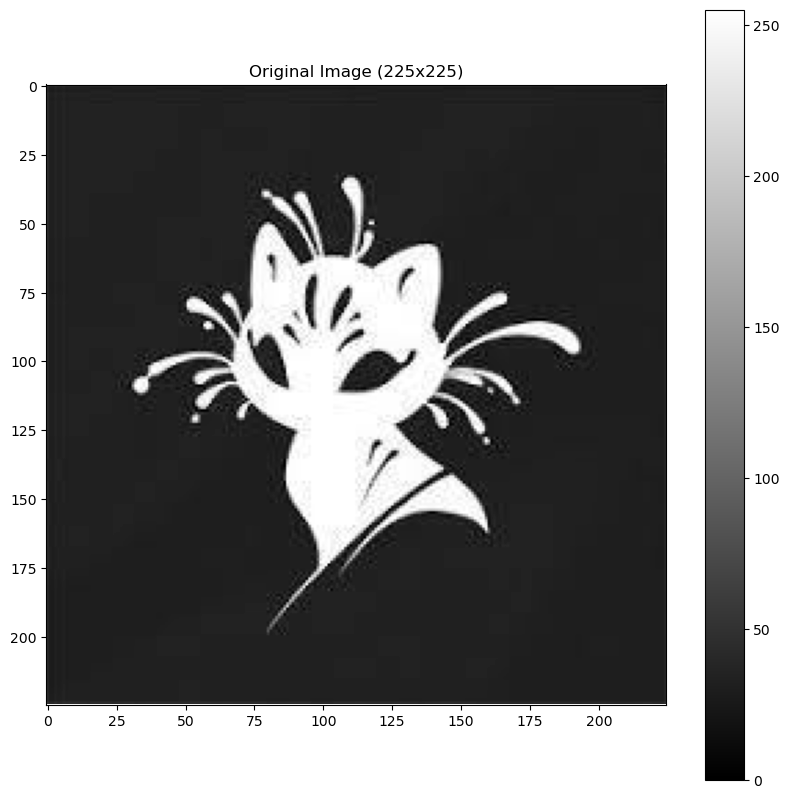

In [64]:


# ===========================
# Step 1: Intensity Values
# ===========================

# Set the file path
file_path = 'cat.csv'  # You can change this to your desired file path, e.g., 'image.png'

# Check file extension
file_extension = os.path.splitext(file_path)[1].lower()  # Get the file extension

if file_extension == '.csv':
    # Reading intensity values from CSV file
    intensities = []
    with open(file_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            intensities.append([float(value) for value in row])  # Convert each value to float and append as a row
    intensities = np.array(intensities)

elif file_extension in ['.png', '.jpg', '.jpeg']:
    # Reading image files (PNG, JPEG, JPG)
    image = Image.open(file_path).convert('L')  # Convert the image to grayscale
    intensities = np.array(image, dtype=np.float32)  # Convert to NumPy array of float values (for consistency)

else:
    raise ValueError(f"Unsupported file type: {file_extension}. Only CSV, PNG, JPG, and JPEG are supported.")

# Determine image size dynamically based on the shape of the intensity matrix
rows, cols = intensities.shape
num_pixels = rows * cols  # Total number of pixels


# Parameters 
intensity_std = np.std(intensities) # get standard deviation of all intensities
sigma = intensity_std * 0.005 # set sigma with .005 scaling factor
sigma=1
print(sigma)

# Display the original image
plt.figure(figsize=(10, 10))
plt.imshow(intensities, cmap='gray')
plt.title(f'Original Image ({rows}x{cols})')
plt.colorbar()
plt.show()


In [65]:
# ===========================
# Step 2: Identify Source and Sink Pixels
# ===========================

# minimum and maximum intensity values
min_intensity = np.min(intensities)
max_intensity = np.max(intensities)

# Get positions (row, col) of the source (lowest intensity) and sink (highest intensity)
source_positions = np.argwhere(intensities == min_intensity)
sink_positions = np.argwhere(intensities == max_intensity)

# Selecting one of the pixels in case of multiple minima/maxima 
# here I am choosing the 1st value, if you change the local minima/maxima in case of multiple values,
#the dfs output gives a diff answer depending on how many minima/maxima exist (try BFS)

source_row, source_col = source_positions[0]
sink_row, sink_col = sink_positions[0]

# Calculate pixel numbers
# NOTE: this needs to be updated to image_size[0] when using dynamic input
source_pixel = source_row * cols + source_col
sink_pixel = sink_row * cols + sink_col

print(f"Source pixel position: ({source_row}, {source_col}), Pixel number: {source_pixel}")
print(f"Sink pixel position: ({sink_row}, {sink_col}), Pixel number: {sink_pixel}")


Source pixel position: (39, 107), Pixel number: 8882
Sink pixel position: (36, 109), Pixel number: 8209


In [66]:

# ===========================
# Step 3: The Network
# ===========================

# Build the network edges with similarities
edges = {}  # Keys are (i, j) tuples, values are similarities

for row in range(rows): 
    for col in range(cols): 
        pixel_i = row * cols + col

        # Define neighbor relative positions (dr is change in index of row and dc change in index of column
        for dr in [-1, 0, 1]: #looping for every neighbour from {[(-1,-1) (-1,0) (-1,1)],[(0,-1) (0,0) (0,1)],[(0,-1) (1,0) (1,1)]}
            for dc in [-1, 0, 1]:
                if dr == 0 and dc == 0:
                    continue  # Skipping (0,0) pixel as its not a neighbour to itself 

                neighbor_row = row + dr #getting the neighbouring row row_num is given by the row adding -1,1 or 0
                neighbor_col = col + dc #getting the neighbouring col col_num is given by the col adding -1,1 or 0

                # Checking for valid neighbor positions within image boundaries (between 0 to 20/128 based on the size of the image)
                if 0 <= neighbor_row < rows and 0 <= neighbor_col < cols:
                    pixel_j = neighbor_row * cols + neighbor_col

                    # To ensure each edge is processed once
                    if pixel_i < pixel_j:
                        # Similarity calculations
                        Ii = intensities[row, col]
                        Ij = intensities[neighbor_row, neighbor_col]
                        similarity = np.ceil(100 * np.exp(-((Ii - Ij) ** 2) / (2 * sigma ** 2))) #given by prof sigma gives the variance ie. sensitivity (less sensi = high sigma value)

                        # Store the edge with its similarity in the edges key value pair
                        edges[(pixel_i, pixel_j)] = similarity

#edges
'''
output of edges for the triangle image:
(146, 147): 100.0,
 (146, 165): 100.0,
 (146, 166): 100.0,
 (146, 167): 100.0,
 (147, 148): 100.0,
 (147, 166): 100.0,
 (147, 167): 100.0,
 (147, 168): 1.0,
 (148, 149): 100.0,
 (148, 167): 100.0,
 (148, 168): 1.0,
 (148, 169): 100.0,
 (149, 150): 100.0,
 (149, 168): 1.0,
 (149, 169): 100.0,
 (149, 170): 14.0,
 (150, 151): 100.0,
 (150, 169): 100.0,
 (150, 170): 14.0,
 (150, 171): 100.0,
 (151, 152): 100.0,
 (151, 170): 14.0,
 (151, 171): 100.0,
 (151, 172): 100.0,
 (152, 153): 100.0,}

'''

'\noutput of edges for the triangle image:\n(146, 147): 100.0,\n (146, 165): 100.0,\n (146, 166): 100.0,\n (146, 167): 100.0,\n (147, 148): 100.0,\n (147, 166): 100.0,\n (147, 167): 100.0,\n (147, 168): 1.0,\n (148, 149): 100.0,\n (148, 167): 100.0,\n (148, 168): 1.0,\n (148, 169): 100.0,\n (149, 150): 100.0,\n (149, 168): 1.0,\n (149, 169): 100.0,\n (149, 170): 14.0,\n (150, 151): 100.0,\n (150, 169): 100.0,\n (150, 170): 14.0,\n (150, 171): 100.0,\n (151, 152): 100.0,\n (151, 170): 14.0,\n (151, 171): 100.0,\n (151, 172): 100.0,\n (152, 153): 100.0,}\n\n'

In [67]:
# ===========================
# Step 4: Build the Adjacency Listc (graphs concept)
# ===========================
'''
An adjacency list represents a graph as a collection of lists. Each vertex in the graph has a corresponding list that 
contains all the vertices adjacent to it (i.e., directly connected by an edge)
For us it will be the neighbours

for example: if we had a pixel that is in the centre then it will have 8 values in its list and each value in the list 
will be the node number or the pixel number of its neighbour whose combination with the main pixel is stored in the key value pair above in the edges 
'''


# Initialize adjacency list
nodes = range(num_pixels) # (0 to rows*columns) ( 0 to total no of nodes/pixels)
adjacency = {i: [] for i in nodes} #chatgpt-4o # I forgot how to create adjacency liist that varies its size -- python doesnt need the size apparently
#The above code Initializes an empty adjacency list as a dictionary, 
#where each key is a node (pixel index), and the corresponding value is an empty list to store adjacent nodes

# Populate adjacency list
for (i, j) in edges.keys(): # why i,j? -- the edges' key is 2 units x and y
    adjacency[i].append(j) #appending all nodes based on the edges
    adjacency[j].append(i) #symmetric

#for the above for loop assume that we have (1,2) and (1,3) then the adjacency[1]=[2,3], adjacency[2]=[1] and adjacency[3]=[1] 
# if you loop through all the keys in edges you will get each nodes connection with its neighboour


In [68]:
#adjacency

In [69]:

# ===========================
# Step 5: Set Up the Optimization Model in Gurobi
# ===========================


m = Model('MaxFlow')
m.setParam('OutputFlag', 0)  # :) I had forgotten

# Create flow variables for each edge in both directions
flow_vars = {}

#adding a variable to every pixel connection and creating separate connection (i,j) and (j,i) Why? idk.. I just went with it, if you wanna try optimizing it then feel free to do so
# chatgpt suggested do it both way -- it worked -- so keeping it
for (i, j), capacity in edges.items(): #the similarity is then considered as capacity of flow between the nodes
    var_name_ij = f'flow_{i}_{j}' #fancy chatgpt way to say 'flow_1_2'(string) for the flow between edge (1,2)
    var_name_ji = f'flow_{j}_{i}' #symmetric

    flow_vars[(i, j)] = m.addVar(lb=0, ub=capacity, vtype=GRB.CONTINUOUS, name=var_name_ij) #flow cannot be greater than capacity/similarity of the edge and cant be negative
    flow_vars[(j, i)] = m.addVar(lb=0, ub=capacity, vtype=GRB.CONTINUOUS, name=var_name_ji)


In [70]:

# ===========================
# Step 6: Add Flow Conservation Constraints
# ===========================

# Flow conservation for all nodes except source and sink
for i in nodes:
    if i == source_pixel or i == sink_pixel:
        continue  # Skip source and sink

    # Calculate total inflow and outflow for node i and they should be equal
    inflow = quicksum(flow_vars[(j, i)] for j in adjacency[i] if (j, i) in flow_vars)
    outflow = quicksum(flow_vars[(i, j)] for j in adjacency[i] if (i, j) in flow_vars)

    # Add flow conservation constraint
    m.addConstr(inflow == outflow, name=f'flow_conservation_{i}') #chatgpt suggested to add name for debugging


In [71]:

# ===========================
# Step 7: Define Objective Function
# ===========================

# Calculate net flow at the source
inflow_source = quicksum(flow_vars[(j, source_pixel)] for j in adjacency[source_pixel] if (j, source_pixel) in flow_vars)
outflow_source = quicksum(flow_vars[(source_pixel, j)] for j in adjacency[source_pixel] if (source_pixel, j) in flow_vars)
net_flow_source = outflow_source - inflow_source

# Set objective to maximize net flow from source
m.setObjective(net_flow_source, GRB.MAXIMIZE)

# ===========================
# Step 8: Optimize the Model
# ===========================

m.optimize()

# ===========================
# Step 9: Output the Results
# ===========================

# Print the total maximum flow from source to sink
print(f"Maximum flow from source to sink: {m.ObjVal}") # might come zero but the outline does come properly


Maximum flow from source to sink: -0.0


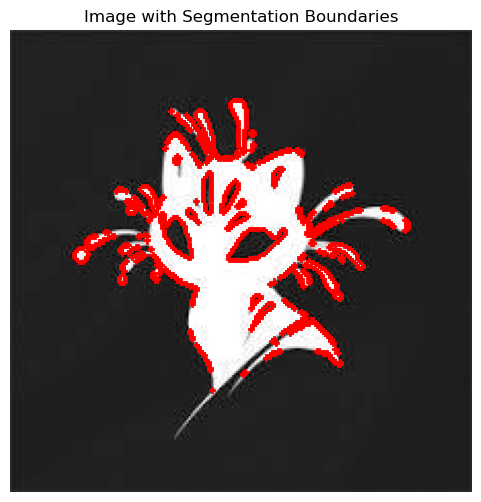

In [72]:
# ===========================
# Step 10: Extract Min Cut and Plot Segmentation Boundaries
# ===========================


# Check if the model found an optimal solution
if m.status == GRB.OPTIMAL:
    # Extract flow values from the solution
    flow_values = {}
    for (i, j), var in flow_vars.items():
        flow_values[(i, j)] = var.X

    # Building the residual graph based on the flow values
    residual_graph = {i: [] for i in nodes}
    for (i, j), capacity in edges.items():
        # Residual capacity in the forward direction (i -> j)
        residual_capacity_ij = capacity - flow_values.get((i, j), 0)
        # Residual capacity in the backward direction (j -> i)
        residual_capacity_ji = capacity - flow_values.get((j, i), 0)

        if residual_capacity_ij > 1e-6:
            residual_graph[i].append(j)
        if residual_capacity_ji > 1e-6:
            residual_graph[j].append(i)

    # Perform BFS from the source to find all reachable nodes
    reachable = set()
    queue = [source_pixel]
    while queue:
        current = queue.pop(0)
        if current not in reachable:
            reachable.add(current)
            for neighbor in residual_graph[current]:
                if neighbor not in reachable:
                    queue.append(neighbor)
    
    #reachable
    
    # Nodes not reachable from the source
    non_reachable = set(nodes) - reachable
    
    #non_reachable
    
    # Identifying the min cut edges (edges from reachable to non-reachable nodes)
    min_cut_edges = []
    for (i, j) in edges.keys():
        if (i in reachable and j in non_reachable):
            min_cut_edges.append((i, j))
        elif (j in reachable and i in non_reachable):
            min_cut_edges.append((j, i))

    # ===========================
    # Step Y: Overlay Boundaries on the Original Image (DOING IT FOR THE LEFT RIGHT TOP AND BOTTOM PIXELS ONLY, 
    #IF DIAGONALS ARE INCLUDED THEN IT CREATES A HOURGLASS SHAPE LIKE AN 8 AROUND THE BORDER )
    # ===========================

    # Create an image to display the boundaries
    boundaries = np.zeros((rows, cols))

    # Initialize figure for plotting
    plt.figure(figsize=(6, 6))
    plt.imshow(intensities, cmap='gray')

    # For each min cut edge, mark the boundary between pixels
    for (i, j) in min_cut_edges:
        row_i, col_i = divmod(i, cols)
        row_j, col_j = divmod(j, cols)

        # Only consider horizontal and vertical neighbors, ignore diagonal ones
        if (abs(row_i - row_j) == 1 and col_i == col_j) or (abs(col_i - col_j) == 1 and row_i == row_j):
            # Draw a line between the centers of pixels i and j
            plt.plot([col_i, col_j], [row_i, row_j], color='red', linewidth=2)

    # Finalize and show the plot
    plt.title('Image with Segmentation Boundaries')
    plt.axis('off')
    plt.show()

else:
    print("Optimization was not successful. Status code:", m.status)
